In [137]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
from random import randint
import os
import tensorflow as tf
from PIL import Image
from sklearn.metrics import confusion_matrix
import skimage

Dataset location specification

In [0]:
DATASET_DIR = os.path.join('/content', 'drive', 'My Drive', 'Colab Notebooks', 'HW2', 'data')

training_file = os.path.join(DATASET_DIR, 'train.p')
validation_file = os.path.join(DATASET_DIR, 'valid.p')
testing_file = os.path.join(DATASET_DIR, 'test.p')

Load dataset

In [0]:
with open(training_file, 'rb') as f:
    train = pickle.load(f)
with open(validation_file, 'rb') as f:
    valid = pickle.load(f)
with open(testing_file, 'rb') as f:
    test = pickle.load(f)

x_train, y_train = train['features'], train['labels']
x_validation, y_validation = valid['features'], valid['labels']
x_test, y_test = test['features'], test['labels']

Summary of Dataset

In [141]:
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)
print(x_test.shape, y_test.shape)

ListOfClass = list(set(y_train))
NumOfClass = len(ListOfClass)
print(NumOfClass)

Label = [
    'Speed limit (20km/h)',
    'Speed limit (30km/h)',
    'Speed limit (50km/h)',
    'Speed limit (60km/h)',
    'Speed limit (70km/h)',
    'Speed limit (80km/h)',
    'End of speed limit (80km/h)',
    'Speed limit (100km/h)',
    'Speed limit (120km/h)',
    'No passing',
    'No passing for vehicles over 3.5 metric tons',
    'Right-of-way at the next intersection',
    'Priority road',
    'Yield',
    'Stop',
    'No vehicles',
    'Vehicles over 3.5 metric tons prohibited',
    'No entry',
    'General caution',
    'Dangerous curve to the left',
    'Dangerous curve to the right',
    'Double curve',
    'Bumpy road',
    'Slippery road',
    'Road narrows on the right',
    'Road work',
    'Traffic signals',
    'Pedestrians',
    'Children crossing',
    'Bicycles crossing',
    'Beware of ice/snow',
    'Wild animals crossing',
    'End of all speed and passing limits',
    'Turn right ahead',
    'Turn left ahead',
    'Ahead only',
    'Go straight or right',
    'Go straight or left',
    'Keep right',
    'Keep left',
    'Roundabout mandatory',
    'End of no passing',
    'End of no passing by vehicles over 3.5 metric tons',
]

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)
43


Exploration and Visualization

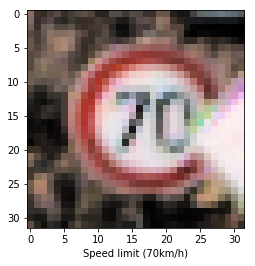

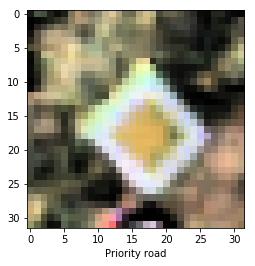

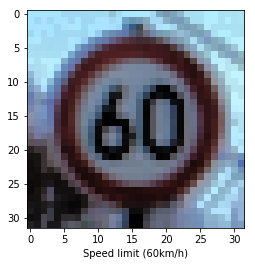

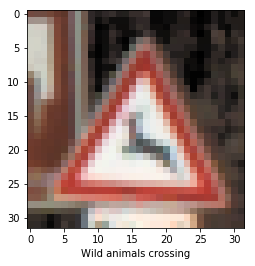

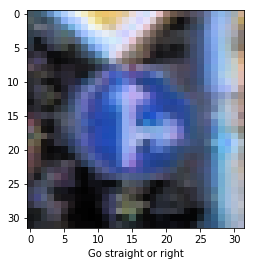

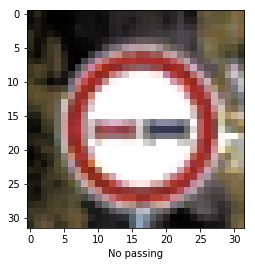

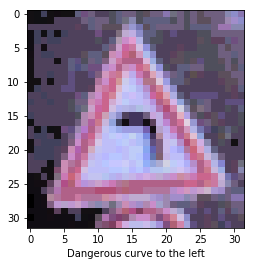

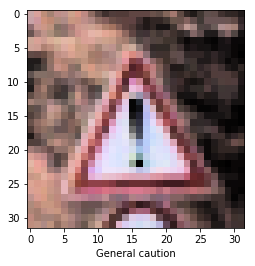

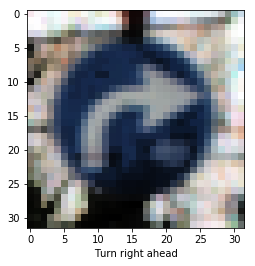

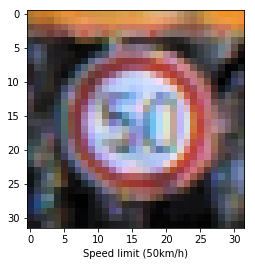

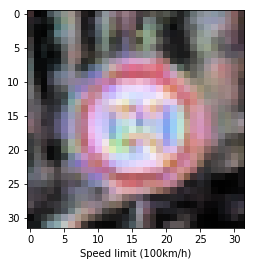

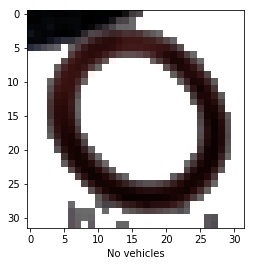

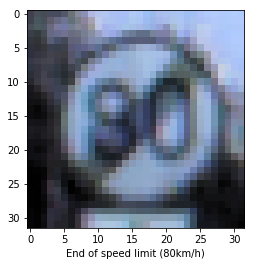

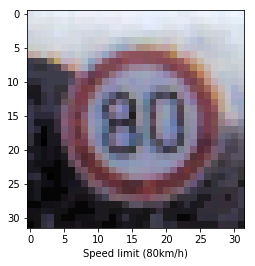

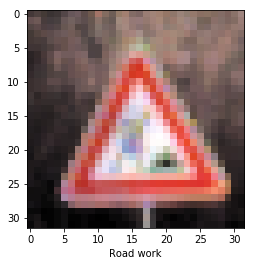

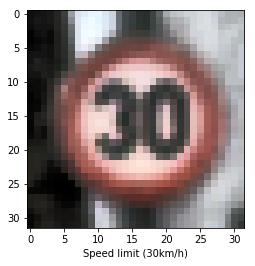

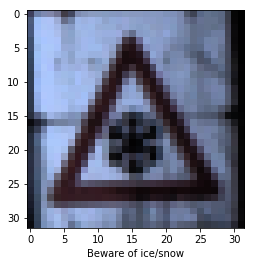

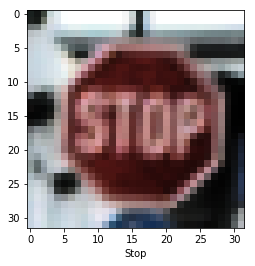

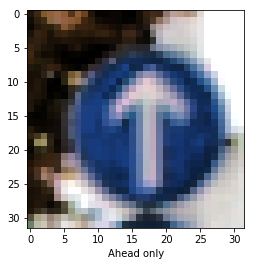

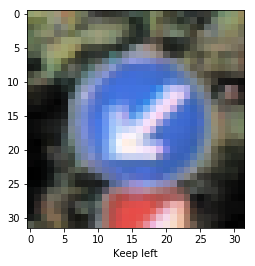

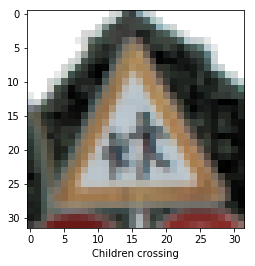

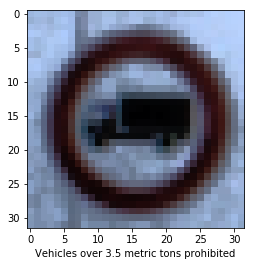

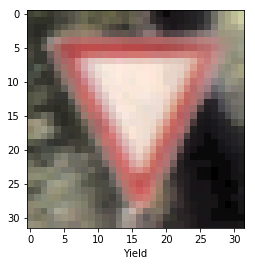

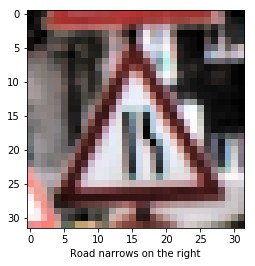

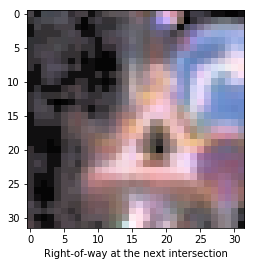

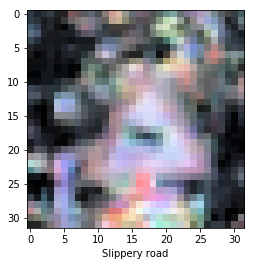

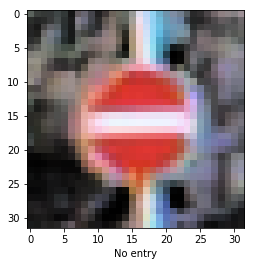

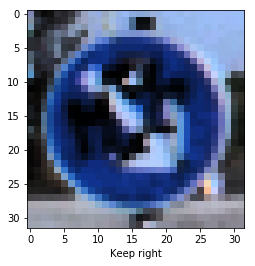

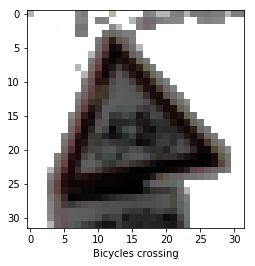

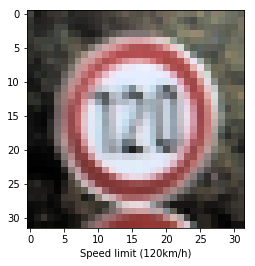

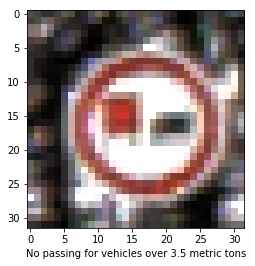

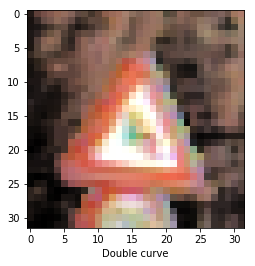

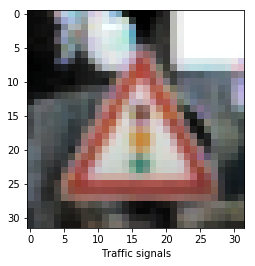

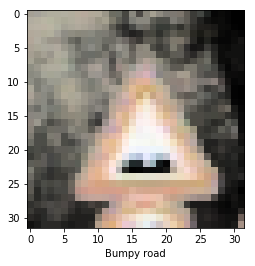

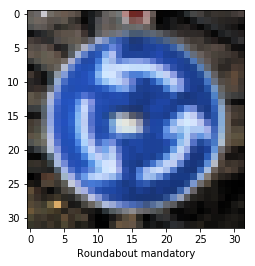

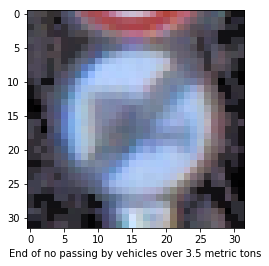

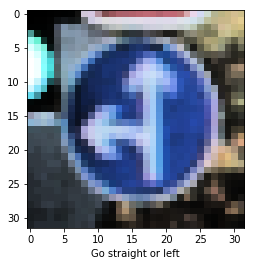

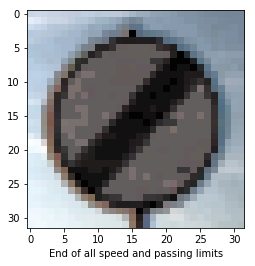

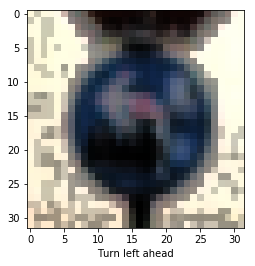

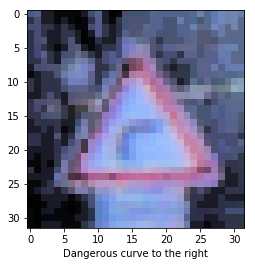

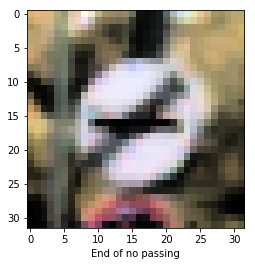

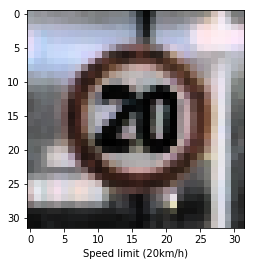

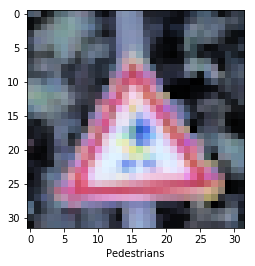

In [201]:
if not os.path.exists('sample'):
    os.mkdir('sample')

flag = np.zeros(NumOfClass, dtype=int)
cnt = NumOfClass
while cnt > 0:
    idx = randint(1, len(y_train))-1
    label = y_train[idx]
    if flag[label] == 0:
        flag[label] = 1
        cnt -= 1
        plt.imshow(x_train[idx])
        plt.xlabel(Label[label])
        plt.savefig('sample/{:d}.png'.format(label))
        plt.show()

Process the dataset

In [0]:
def hist_eq_v(img):
  hsv_img = skimage.color.rgb2hsv(img)
  
  v_channel = hsv_img[:, :, 2]
  v_min = np.min(v_channel)
  v_max = np.max(v_channel)
  
  if v_max - v_min < 128:
    hsv_img[:, :, 2] = skimage.exposure.equalize_hist(hsv_img[:, :, 2])
    new_img = skimage.color.hsv2rgb(hsv_img)
    return new_img
  else:
    return img

In [220]:
x_train = np.array([hist_eq_v(img) for img in x_train])
print(x_train.shape)
x_validation = np.array([hist_eq_v(img) for img in x_validation])
print(x_validation.shape)
x_test = np.array([hist_eq_v(img) for img in x_test])
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


Building model...

In [221]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(NumOfClass, activation='softmax'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 28, 28, 128)       36992     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 6, 6, 128)       

Compiling model...

In [0]:
loc_optimizer = tf.keras.optimizers.Adam(lr=1e-3, )
loc_loss = tf.keras.losses.sparse_categorical_crossentropy
loc_metrics = ['accuracy']
model.compile(optimizer=loc_optimizer,loss=loc_loss,metrics=loc_metrics)

Fitting model...

In [223]:
r0 = model.fit(x_train.astype(np.float32), y_train.astype(np.float32), validation_data=(x_validation, y_validation), verbose = 1, batch_size = 128, epochs=8)

Train on 34799 samples, validate on 4410 samples
Epoch 1/8
34799/34799 [==============================] - 12s 355us/sample - loss: 1.6943 - acc: 0.5564 - val_loss: 5.8757 - val_acc: 0.0476
Epoch 2/8
34799/34799 [==============================] - 11s 313us/sample - loss: 0.3360 - acc: 0.8960 - val_loss: 1.7502 - val_acc: 0.4422
Epoch 3/8
34799/34799 [==============================] - 11s 313us/sample - loss: 0.1620 - acc: 0.9487 - val_loss: 0.0729 - val_acc: 0.9776
Epoch 4/8
34799/34799 [==============================] - 11s 310us/sample - loss: 0.1022 - acc: 0.9685 - val_loss: 0.0734 - val_acc: 0.9796
Epoch 5/8
34799/34799 [==============================] - 11s 310us/sample - loss: 0.0826 - acc: 0.9744 - val_loss: 0.0645 - val_acc: 0.9816
Epoch 6/8
34799/34799 [==============================] - 11s 312us/sample - loss: 0.0664 - acc: 0.9789 - val_loss: 0.0896 - val_acc: 0.9730
Epoch 7/8
34799/34799 [==============================] - 11s 309us/sample - loss: 0.0531 - acc: 0.9827 - val_lo

History of training

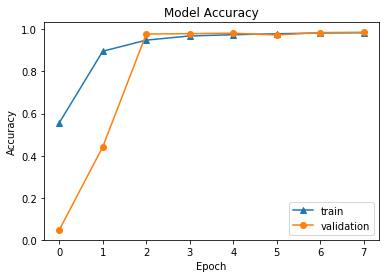

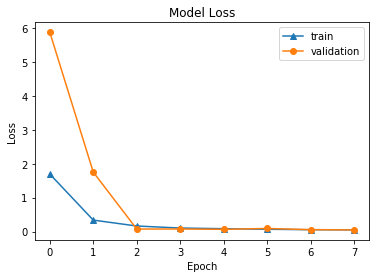

In [224]:
plt.plot(r0.history['acc'], '-^')
plt.plot(r0.history['val_acc'], '-o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(r0.history['loss'], '-^')
plt.plot(r0.history['val_loss'], '-o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Evaluating model...

In [225]:
r1 = model.evaluate(x_test.astype(np.float32), y_test.astype(np.float32), verbose = 1)
print("Loss: ", r1[0])
print("Accuracy: ", r1[1])

12630/12630 [==============================] - 3s 237us/sample - loss: 0.1132 - acc: 0.9714
Loss:  0.11322703438597899
Accuracy:  0.97141725


Analyse testing accuracy

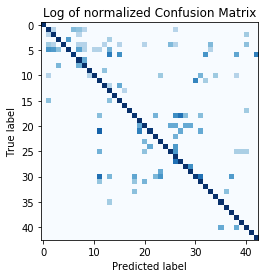

In [226]:
pred_test = model.predict_classes(x_test)
cm = confusion_matrix(y_test, pred_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Predicting on 10 figures randomly choosen from testing dataset ...

In [227]:
idx = []
cnt = 0
while cnt < 10:
  loc_idx = randint(0, 12630)
  if loc_idx not in idx:
    idx.append(loc_idx)
    cnt = cnt + 1

pred = model.predict_classes(np.array([x_test[e] for e in idx]))
judgement = []

print("{:>8s}{:>64s}{:>64s}{:>12s}".format("Index", "Prediction", "Actual", "Judgement"))
for i in range(10):
  loc_idx = idx[i]
  loc_pred = pred[i]
  loc_ans = y_test[idx[i]]
  loc_judge = pred[i]== y_test[idx[i]]
  judgement.append(loc_judge)
  print("{:>8d}{:>64s}{:>64s}{:>12b}".format(loc_idx, Label[loc_pred], Label[loc_ans], loc_judge))
  
for i in range(10):
  if not judgement[i]:
    loc_idx = idx[i]
    plt.figure()
    loc_img = np.squeeze(x_test[loc_idx])
    plt.imshow(loc_img)
    plt.colorbar()
    plt.grid(False)
    plt.xlabel("\'{:s}\' is mistaken for \'{:s}\'".format(Label[y_test[loc_idx]], Label[pred[i]]))
    plt.show()

   Index                                                      Prediction                                                          Actual   Judgement
    7569                                                 General caution                                                 General caution           1
    6975                                                   Priority road                                                   Priority road           1
    3297                                                           Yield                                                           Yield           1
   12149                                                 Traffic signals                                                 Traffic signals           1
   12226                                                 Traffic signals                                                 Traffic signals           1
    8480                                                   Slippery road                                  

Load images downloaded from Internet and adjust size


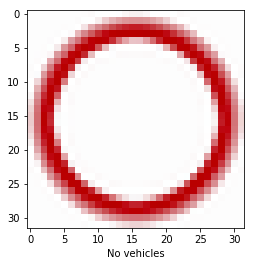

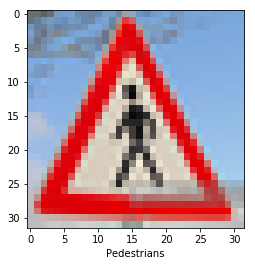

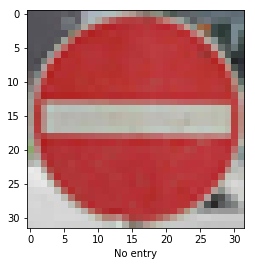

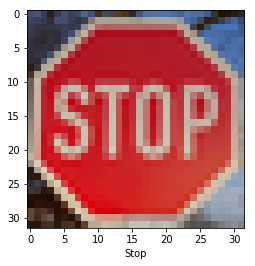

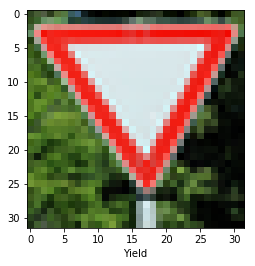

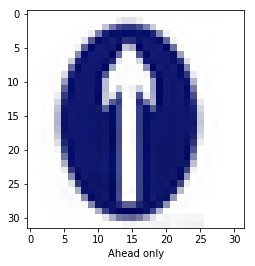

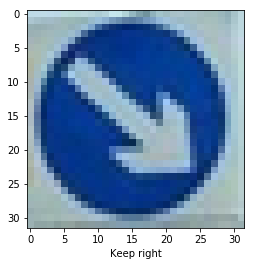

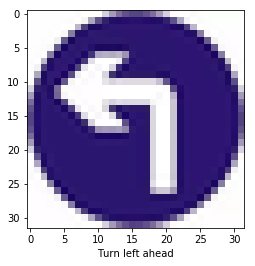

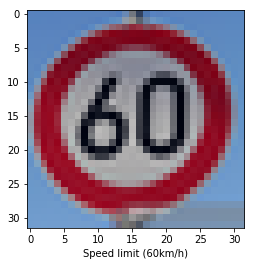

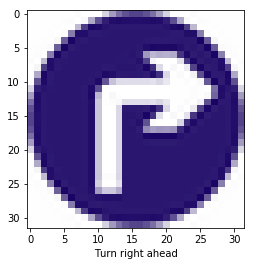

(10, 32, 32, 3)


In [228]:
DOWNLOAD_DIR = os.path.join('/content', 'drive', 'My Drive', 'Colab Notebooks', 'HW2', 'download')

x_download = []
y_download = np.zeros(10, dtype='int')

cnt = 0
for e in os.listdir(DOWNLOAD_DIR):
  label, ext = e.split('.')
  cur_path = os.path.join(DOWNLOAD_DIR, e)
  cur_img = Image.open(cur_path)
  adj_img = cur_img.resize((32, 32), Image.ANTIALIAS)
  

  x_download.append(np.array(adj_img))
  y_download[cnt] = int(label)
  
  plt.imshow(x_download[cnt])
  plt.xlabel(Label[y_download[cnt]])
  plt.show()
  
  cnt += 1

x_download = np.array(x_download)
print(x_download.shape)

Predict on downloaded images

   Index                                                      Prediction                                                          Actual   Judgement
       0                                                     No vehicles                                                     No vehicles           1
       1                                                     Pedestrians                                                     Pedestrians           1
       2                                                        No entry                                                        No entry           1
       3                                                            Stop                                                            Stop           1
       4                                                           Yield                                                           Yield           1
       5                                                      Ahead only                                  

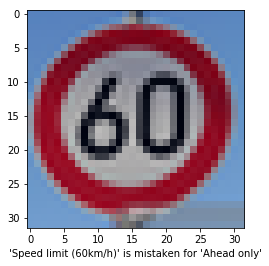

In [229]:
download_pred = model.predict_classes(x_download)
download_judge = download_pred == y_download

print("{:>8s}{:>64s}{:>64s}{:>12s}".format("Index", "Prediction", "Actual", "Judgement"))
for i in range(10):
  loc_pred = download_pred[i]
  loc_ans = y_download[i]
  print("{:>8d}{:>64s}{:>64s}{:>12b}".format(i, Label[loc_pred], Label[loc_ans], download_judge[i]))
  
for i in range(10):
  if not download_judge[i]:
    plt.imshow(x_download[i])
    plt.xlabel("\'{:s}\' is mistaken for \'{:s}\'".format(Label[y_download[i]], Label[download_pred[i]]))
    plt.show()


Top 5 softmax probabilities

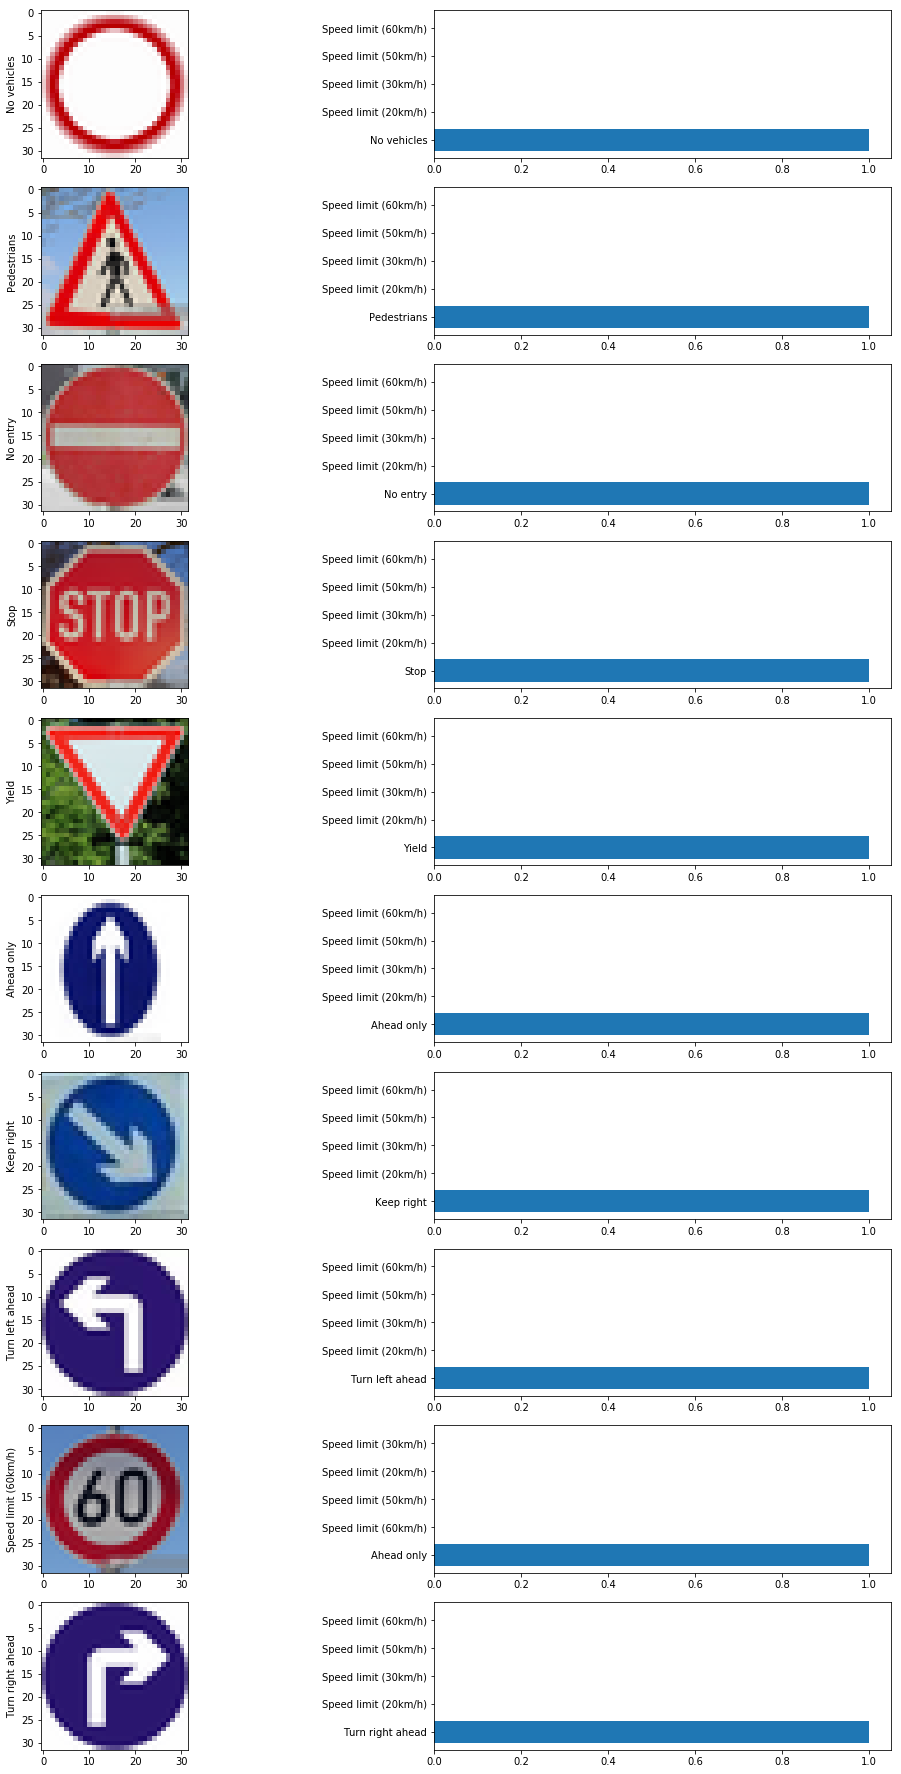

In [230]:
pred_download = model.predict(x_download)

plt.figure(figsize=(18, 32))
for i in range(10):
  plt.subplot(10, 2, 2*i+1)
  plt.imshow(x_download[i])
  plt.ylabel(Label[y_download[i]])
  plt.grid(False)
  
  plt.subplot(10, 2, 2*i+2)
  stat = list(zip(pred_download[i], Label))
  stat.sort(key=lambda e: e[0], reverse=True)
  
  plt.barh(np.arange(1, 6, 1), [stat[j][0] for j in range(5)])
  plt.yticks(np.arange(1, 6, 1), [stat[j][1] for j in range(5)])
  
plt.show()
